# Evaluate 

In [1]:
import sys
print(sys.executable, sys.version)


import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import trimesh

from os.path import join, abspath
from IPython.display import display, HTML
from glob import glob

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

%matplotlib inline

# for local import 
sys.path.append(abspath('../src/'))

from main.config import Config
from main.model import Model
from main.dataset import Dataset
from main.smpl import Smpl

from utils import draw_2d_on_image, show_2d_pose, show_3d_pose

/home/mmc-user/.virtualenvs/hmr2.0/bin/python3 3.6.8 (default, Oct  7 2019, 12:59:55) 
[GCC 8.3.0]


In [2]:
#eval_date = '22032020-231404'
eval_date = '30032020-202912'
class EvalConfig(Config):
    ENCODER_ONLY = True
    LOG_DIR = join('/', 'data', 'ssd1', 'russales', 'logs', eval_date)
    DATA_DIR = join('/', 'data', 'ssd1', 'russales', 'new_records')
    # RESTORE_PATH = join(LOG_DIR, 'ckpt-6')

# class Config is implemented as singleton, inizialize subclass first!
config = EvalConfig()

In [3]:
# inizialize model 
model = Model()

Saving logs to /data/ssd1/russales/logs/30032020-202912

Configurations:
BATCH_SIZE                     64
DATASETS                       ['lsp', 'lsp_ext', 'mpii', 'mpii_3d', 'h36m']
DATA_DIR                       /data/ssd1/russales/new_records
DISCRIMINATOR_LEARNING_RATE    0.0001
DISCRIMINATOR_LOSS_WEIGHT      1
DISCRIMINATOR_WEIGHT_DECAY     0.0001
ENCODER_INPUT_SHAPE            (224, 224, 3)
ENCODER_LEARNING_RATE          1e-05
ENCODER_LOSS_WEIGHT            60.0
ENCODER_ONLY                   True
ENCODER_WEIGHT_DECAY           0.0001
EPOCHS                         55
ITERATIONS                     3
JOINT_TYPE                     cocoplus
LOG_DIR                        /data/ssd1/russales/logs/30032020-202912
NUM_CAMERA_PARAMS              3
NUM_JOINTS                     23
NUM_JOINTS_GLOBAL              24
NUM_KP2D                       19
NUM_KP3D                       14
NUM_PARALLEL                   16
NUM_POSE_PARAMS                72
NUM_SAMPLES                    42244

### run evaluation

In [4]:
result = model.test(vis='True')

initialize test dataset...
Done (t=0.3305072784423828)

Start of Testing



Time taken for testing 62.76977777481079 sec



### sort results by sequence 

In [5]:
all_kp3d_mpjpe = result['kp3d_mpjpe'].numpy()
all_kp3d_mpjpe_aligned = result['kp3d_mpjpe_aligned'].numpy()
sequences = result['sequences'].numpy()

### evaluate per sequence 

In [6]:
eval_dict = {}
indices = range(len(sequences))
for i, sequence in zip(indices, sequences):
    sequence = sequence.decode("utf-8")
    mpjpe_tuple = tuple([all_kp3d_mpjpe[i], all_kp3d_mpjpe_aligned[i]])
    if sequence not in eval_dict:
        eval_dict[sequence] = [mpjpe_tuple]
    else:
        eval_dict[sequence].append(mpjpe_tuple)

In [7]:
names, data = eval_dict.keys(), np.ndarray(shape=(len(eval_dict), 9), dtype=np.float32)

indices = range(len(names))
for i, value in zip(indices, eval_dict.values()):
    values_per_seq = np.asarray(value, dtype=np.float32)
    mpjpe = values_per_seq[:, 0, :]
    mpjpe_aligned = values_per_seq[:, 1, :]
    
    mean_mpjpe_aligned = np.mean(mpjpe_aligned)
    mean_mpjpe = np.mean(mpjpe)
    
    data[i, 0] = mean_mpjpe_aligned  # mean_error_aligned
    data[i, 1] = mean_mpjpe  # mean_error
    data[i, 2] = np.median(mpjpe)  # median_error
    data[i, 3] = np.std(mpjpe)  # standard deviation
    data[i, 4] = mpjpe.min()  # min
    data[i, 5] = mpjpe.max()  # max
    data[i, 6] = np.percentile(mpjpe, 25)  # 25 percentile
    data[i, 7] = np.percentile(mpjpe, 50)  # 50 percentile
    data[i, 8] = np.percentile(mpjpe, 75)  # 75 percentile
        
columns = ['Mean Aligned', 'Mean', 'Median', 'Standard Deviation', 'Min', 'Max', '25%', '50%', '75%']
df_seq = pd.DataFrame(data, index=names, columns=columns)

df_seq = df_seq.sort_values(df_seq.columns[0]) # sort by ascending mean aligned

display(HTML(df_seq.to_html()))

,Mean Aligned,Mean,Median,Standard Deviation,Min,Max,25%,50%,75%
h36m_sub11_Directions_cam55011271,69.650299,93.474670,80.503616,60.524296,6.612236,376.264404,47.009666,80.503616,123.155525
h36m_sub11_Discussion 1_cam55011271,72.565506,102.522804,82.901939,72.905869,3.343106,448.155182,45.881321,82.901939,144.689926
h36m_sub11_Directions 1_cam55011271,73.060127,99.816162,82.121933,74.798805,7.947652,833.378662,46.471237,82.121933,137.786209
h36m_sub11_Discussion 2_cam55011271,76.459549,111.732971,90.464752,82.365242,7.027303,664.331909,52.003433,90.464752,145.349091
h36m_sub11_Discussion 2_cam54138969,79.408096,137.811142,95.469559,137.802795,2.648411,1113.215820,54.631264,95.469559,169.602417
h36m_sub11_Discussion 1_cam54138969,79.868744,134.354507,92.103256,152.737778,2.630628,1168.302612,48.850361,92.103256,158.685242
h36m_sub11_Posing 1_cam55011271,80.387947,116.204330,93.644104,82.368118,9.750742,507.032410,53.557415,93.644104,161.446869
h36m_sub11_Posing_cam55011271,81.973640,118.881012,96.274826,86.821915,11.558996,705.187378,57.664631,96.274826,159.996353
h36m_sub11_Discussion 2_cam60457274,82.467651,112.377548,90.985054,82.672729,7.867067,866.631165,54.214390,90.985054,146.356964
h36m_sub11_Posing 1_cam58860488,83.755905,108.652298,90.703033,71.232254,4.686639,476.782715,57.696590,90.703033,136.684479


In [8]:
df_seq.describe()

,Mean Aligned,Mean,Median,Standard Deviation,Min,Max,25%,50%,75%
count,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000
mean,110.149414,212.363968,169.390503,162.403030,9.081069,1062.309082,92.868599,169.390503,284.932617
std,22.666380,86.037956,83.432350,48.424660,6.333642,240.858856,49.409866,83.432350,124.145134
min,69.650299,93.474670,80.503616,60.524296,1.845839,376.264404,45.881321,80.503616,123.155525
25%,96.872337,153.644596,117.969368,125.916639,5.381286,901.386139,65.723158,117.969368,203.815350
50%,105.688747,194.463394,145.503738,157.861374,7.691807,1100.175293,77.747200,145.503738,250.247513
75%,116.385689,233.485542,191.865555,193.333549,10.672631,1214.811523,93.898895,191.865555,310.587303
max,198.590668,578.105530,585.391602,299.501953,56.289646,1686.737427,322.318909,585.391602,819.676147


### evaluate per joint

In [9]:
lsp_joints = ['ankle_r', 'knee_r', 'hip_r', 'hip_l', 'knee_l', 
             'ankle_l', 'wrist_r', 'elbow_r', 'shoulder_r', 
             'shoulder_l', 'elbow_l', 'wrist_l', 'neck', 'brain']

data = np.ndarray(shape=(14, 9), dtype=float)
for i, _ in enumerate(lsp_joints):
    data[i, 0] = np.mean(all_kp3d_mpjpe_aligned[:, i])  # mean_error_aligned
    data[i, 1] = np.mean(all_kp3d_mpjpe[:, i])  # mean_error
    data[i, 2] = np.median(all_kp3d_mpjpe[:, i])  # median_error
    data[i, 3] = np.std(all_kp3d_mpjpe[:, i])  # standard deviation
    data[i, 4] = all_kp3d_mpjpe[:, i].min()  # min
    data[i, 5] = all_kp3d_mpjpe[:, i].max()  # max
    data[i, 6] = np.percentile(all_kp3d_mpjpe[:, i], 25)  # 25 percentile
    data[i, 7] = np.percentile(all_kp3d_mpjpe[:, i], 50)  # 50 percentile
    data[i, 8] = np.percentile(all_kp3d_mpjpe[:, i], 75)  # 75 percentile
        
columns = ['Mean Aligned', 'Mean', 'Median', 'Standard Deviation', 'Min', 'Max', '25%', '50%', '75%']
df_joint = pd.DataFrame(data, index=lsp_joints, columns=columns)
df_joint = df_joint.sort_values(df_joint.columns[0])

display(HTML(df_joint.to_html()))

,Mean Aligned,Mean,Median,Standard Deviation,Min,Max,25%,50%,75%
neck,59.957924,86.429390,62.504795,80.950317,5.004020,918.935120,44.750871,62.504795,94.739180
shoulder_r,61.364262,156.793396,117.725151,112.330513,3.343106,937.968567,68.261072,117.725151,245.283134
hip_l,74.219933,103.854088,66.511505,84.276482,1.845839,287.551697,34.482771,66.511501,180.120403
shoulder_l,74.312553,163.715012,124.171448,113.197739,3.512853,941.956238,76.061481,124.171444,246.506454
hip_r,78.100327,103.854088,66.511925,84.276482,1.845880,287.551453,34.482814,66.511925,180.120396
elbow_r,92.159004,267.471680,195.979355,200.278534,3.711188,1077.886108,101.839931,195.979355,432.782654
brain,95.035233,172.060852,138.551758,126.195625,5.208329,1339.860962,93.328547,138.551765,211.758865
elbow_l,96.317909,282.740601,215.486389,205.125595,2.427972,1098.997314,115.687420,215.486382,439.335213
knee_r,104.504677,183.236252,143.598053,144.888657,3.207626,939.374573,87.011463,143.598053,235.794785
knee_l,105.105042,182.202835,144.509186,137.130829,18.026022,933.274109,93.030621,144.509193,223.262997


In [10]:
df_joint.describe()

,Mean Aligned,Mean,Median,Standard Deviation,Min,Max,25%,50%,75%
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,108.491985,210.564665,165.289091,149.845036,4.489768,1054.494250,99.555572,165.289091,297.489930
std,44.316838,88.852298,77.766860,53.626042,4.052820,409.830100,47.532510,77.766860,127.562610
min,59.957924,86.429390,62.504795,80.950317,1.845839,287.551453,34.482771,62.504795,94.739180
25%,75.259497,158.523800,119.336725,112.547319,2.622885,934.447723,70.211174,119.336724,214.634898
50%,95.676571,182.719543,144.053619,141.009743,3.612020,1009.921173,93.179584,144.053623,245.894794
75%,135.690292,278.923370,217.145313,195.003788,4.560491,1360.911316,137.312922,217.145311,415.881496
max,198.653442,364.368591,302.646973,235.250153,18.026022,1686.737427,180.583130,302.646988,511.882622


### evaluate overall

In [11]:
all_mpjpe_aligned = np.mean(all_kp3d_mpjpe_aligned)
all_mpjpe = np.mean(all_kp3d_mpjpe)

print('Mean Aligned: {:.3f} --- Mean: {:.3f}'.format(all_mpjpe_aligned, all_mpjpe))

Mean Aligned: 108.492 --- Mean: 210.565


In [12]:
percentiles = [10, 30, 50, 70, 90]
data = np.ndarray(shape=(5, 2), dtype=float)
for i, percentile in enumerate(percentiles):
    data[i, 0] = np.percentile(all_kp3d_mpjpe_aligned, percentile)
    data[i, 1] = np.percentile(all_kp3d_mpjpe, percentile)

columns = ['10%', '30%', '50%', '70%', '90%']
df_percentiles = pd.DataFrame(data.T, index=['Mean Aligned', 'Mean'], columns=columns)
df_percentiles

,10%,30%,50%,70%,90%
Mean Aligned,36.110768,60.629914,85.397652,123.911847,216.281276
Mean,45.765343,93.772083,157.883385,248.279454,464.699747


In [13]:
def eval_per_dataset(name):
    len_ds = len([k for k in eval_dict.keys() if name in k])
    data = []

    indices = range(len(eval_dict.keys()))
    for i, (key, value) in zip(indices, eval_dict.items()):
        if name not in key:
            continue

        values_per_seq = np.asarray(value, dtype=np.float32)
        mpjpe = values_per_seq[:, 0, :]
        mpjpe_aligned = values_per_seq[:, 1, :]

        mean_mpjpe_aligned = np.mean(mpjpe_aligned)
        mean_mpjpe = np.mean(mpjpe)
        
        data.append(tuple([mean_mpjpe_aligned, mean_mpjpe]))  
        
    data = np.asarray(data, dtype=float)
    return np.mean(data[:, 0]), np.mean(data[:, 1])

In [14]:
mpjpe_aligned_mpi, mpjpe_mpi = eval_per_dataset('mpi')
print('MPII 3D')
print('Mean Aligned: {:.3f} --- Mean: {:.3f}'.format(mpjpe_aligned_mpi, mpjpe_mpi))

MPII 3D
Mean Aligned: 116.606 --- Mean: 181.483


In [15]:
mpjpe_aligned_mpi, mpjpe_mpi = eval_per_dataset('h36m')
print('HUMAN 3.6M')
print('Mean Aligned: {:.3f} --- Mean: {:.3f}'.format(mpjpe_aligned_mpi, mpjpe_mpi))

HUMAN 3.6M
Mean Aligned: 109.988 --- Mean: 213.136


### save to csv

In [16]:
frames = [df_seq, df_joint]

dataframes = pd.concat(frames)
dataframes.to_csv('evaluation_{}.csv'.format(eval_date))

### Visualize

In [17]:
thetas = result['thetas']
vertices = result['vertices']
rotations = result['rotations']

smpl = Smpl()

In [18]:
mesh = trimesh.Trimesh(vertices=vertices[550], faces=smpl.get_faces(), process=False)

mesh.show()

/home/mmc-user/.virtualenvs/hmr2.0/lib/python3.6/site-packages/trimesh/scene/scene.py:186: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.graph.nodes:


### run inference and visualize

In [19]:
example = join("/data/ssd1/russales/new_records/mpii_3d", "348_test.tfrecord")

# load record
dataset = Dataset()
dataset = dataset.get_data_for(example).shuffle(500, seed=14)

In [20]:
# run inference
for example in dataset.take(1):
    original = example
    result = model.detect(example[0])

#### show original image with ground truth

/home/mmc-user/workspace/hmr2.0/notebooks/utils.py:41: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(joints.dtype, np.float):


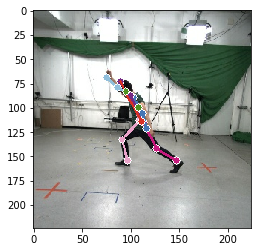

In [21]:
image = original[0].numpy()
kp2d = original[1].numpy()[:, :2]
vis = original[1].numpy()[:, 2]

image = draw_2d_on_image(image, kp2d, vis=vis)
plt.imshow(image)
plt.show()

#### show image with predicted 2d keypoints

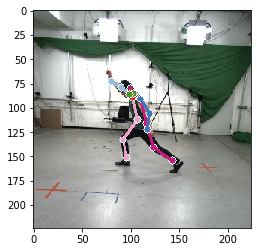

In [22]:
image = original[0].numpy()
kp2d = np.squeeze(result['kp2d'].numpy())
vis = original[1].numpy()[:, 2]
image = draw_2d_on_image(image, kp2d, vis=vis)
plt.imshow(image)
plt.show()

#### show both poses in seperate plots 

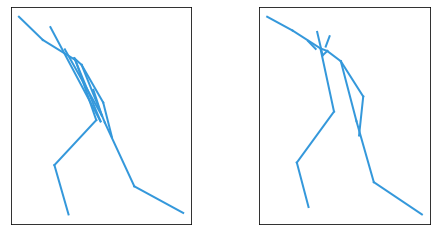

In [23]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

kp2d_real = ((original[1].numpy()[:, :2] + 1) / 2 * image.shape[:2])
show_2d_pose(kp2d_real, ax1)

kp2d_pred = ((np.squeeze(result['kp2d'].numpy()) + 1) / 2 * image.shape[:2])
show_2d_pose(kp2d_pred, ax2)

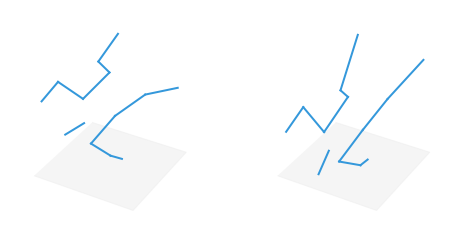

In [24]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

# Plot 3d gt
kp3d_real = original[2].numpy()
show_3d_pose(kp3d_real, ax1)

# Plot 3d predictions
kp3d_pred = np.squeeze(result['kp3d'].numpy())
kp3d_pred = kp3d_pred[:config.NUM_KP3D, :] # only lsp prediction
show_3d_pose(kp3d_pred, ax2)

In [25]:
cam = np.squeeze(result['thetas'].numpy())[:3]
vertices = result['vertices']
smpl = Smpl()

mesh = trimesh.Trimesh(vertices=vertices[0], faces=smpl.get_faces(), process=False)
mesh.show()

/home/mmc-user/.virtualenvs/hmr2.0/lib/python3.6/site-packages/trimesh/scene/scene.py:186: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.graph.nodes:
